In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib.dates as mdates
def arima_model(series, data_split, params, future_periods, log):
  #log transformation
  if log==True:
    series_dates = series.index
    series = pd.Series(np.log(series), index=series.index)
  size = int(len(series)*data_split)
  train, test = series[0:size], series[size:len(series)]
  history = [val for val in train]
  predictions = []

  for t in range(len(test)):
    model = ARIMA(history, order=(params[0], params[1], params[2]))
    model_fit = model.fit(disp = 0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat[0])
    obs = test[t]
    history.append(obs)
    
   # forecasts future periods past the input testing series based on user input
  future_forecast = model_fit.forecast(future_periods)[0]
  future_dates = [test.index[-1]+timedelta(i*365/12) for i in range(1, future_periods+1)]
  test_dates = test.index
    
    # if the data was originally log transformed, the inverse transformation is performed
  if log == True:
        predictions = np.exp(predictions)
        test = pd.Series(np.exp(test), index=test_dates)
        future_forecast = np.exp(future_forecast)
    
 # creates pandas series with datetime index for the predictions and forecast values
  forecast = pd.Series(future_forecast, index=future_dates)
  predictions = pd.Series(predictions, index=test_dates)

  fig = plt.figure()
  ax = fig.add_subplot(111)
  myFmt = mdates.DateFormatter( ' %m%/%y')
  ax.xaxis.set_major_formatter(myFmt)
  plt.plot(predictions, c = 'red')
  plt.plot(test)
  plt.show()

  error = np.sqrt(mean_squared_error(predictions, test))
  print('Test RMSE: %.3f' % error)
  
  return predictions, test, future_forecast

In [ ]:
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
    df = df.dropna()
    print(df.tail())

    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index
    
    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, look_back))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

In [ ]:
def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    
    # reversing differencing if log transformed as well
    if (transforms[1] == True) & (transforms[0] == True):
        train_predict = pd.Series(train_predict + np.log(data_series.shift(1)), index=train_dates).dropna()
        y_train = pd.Series(y_train + np.log(data_series.shift(1)), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + np.log(data_series.shift(1)), index=test_dates).dropna()
        y_test = pd.Series(y_test + np.log(data_series.shift(1)), index=test_dates).dropna()
    
    # reversing differencing if no log transform
    elif transforms[1] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
      
    # reversing log transformation
    if transforms[0] == True:
        train_predict = pd.Series(np.exp(train_predict), index=train_dates)
        y_train = pd.Series(np.exp(y_train), index=train_dates)

        test_predict = pd.Series(np.exp(test_predict), index=test_dates)
        y_test = pd.Series(np.exp(y_test), index=test_dates)
        
    return train_predict, y_train, test_predict, y_test

In [ ]:
def lstm_model(data_series, look_back, split, transforms, lstm_params):
    np.random.seed(1)
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_series, look_back, split, transforms)

    # training the model
    model = Sequential()
    model.add(LSTM(lstm_params[0], input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # inverse transforming results
    train_predict, y_train, test_predict, y_test = \
    inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    myFmt = mdates.DateFormatter('%m%/%y')
    ax.xaxis.set_major_formatter(myFmt)
    plt.plot(y_test)
    plt.plot(test_predict, color='red')
    plt.show()
    
    #calculating RMSE metrics
    error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % error)
    error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % error)
    
    return train_predict, y_train, test_predict, y_test

In [ ]:
def gauss_compare(original_series, predictions, data_split):

  #the train/test split used to generate the Gaussian-filtered predictions
  size = int(len(original_series)*data_split)

  #creating a plot of the original series and Gaussian-filtered predictions
  fig = plt.figure()
  ax = fig.add_subplot(111)
  myFmt = mdates.DateFormatter('%m/%y')
  ax.xaxis.set_major_formatter(myFmt)
  
  plt.plot(original_series[size:])
  plt.plot(predictions, color='red')
  plt.title('Gauss-Filtered Predictions vs. Original Series')
  plt.show()

  #calculating the RMSE between the Gaussian-filtered predictions and orignal dataset
  #the +1 exception code is required when differencing is performed, as the earliest data point can be last

  try: 
    error = np.sqrt(mean_squared_error(predictions, original_series[size:]))
  except: 
    error = np.sqrt(mean_squared_error(predictions, original_series[size +1:]))
  print('Test RMSE: %.3f' % error)


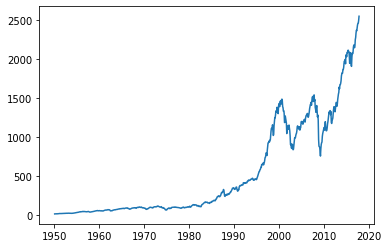

In [ ]:
sp500 = pd.read_csv('sphist.csv', parse_dates=['Date'], index_col="Date")
sp500_monthly = sp500.resample('M').mean()
sp500_ts = sp500_monthly.Close
plt.plot(sp500_ts)

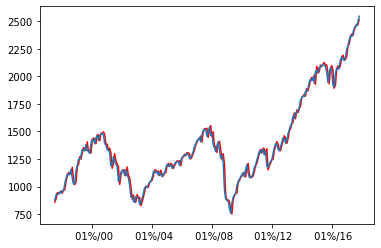

Test RMSE: 45.495


In [ ]:
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(sp500_ts, data_split, params, future_periods, log)

                 t-0       t-1
Date                          
2017-06-30  0.714528  0.712058
2017-07-31  0.691780  0.714528
2017-08-31  0.670215  0.691780
2017-09-30  0.711003  0.670215
2017-10-31  0.729169  0.711003


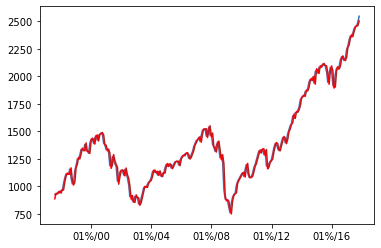

Train RMSE: 7.126
Test RMSE: 45.709


In [ ]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(sp500_ts, look_back, split, transforms, lstm_params)

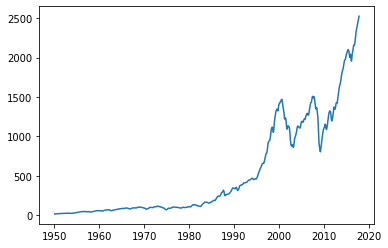

In [ ]:
sp500_ts_gauss = pd.Series(gaussian_filter(sp500_ts, sigma=1), index=sp500_ts.index).astype(float)
plt.plot(sp500_ts_gauss)
plt.show()


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


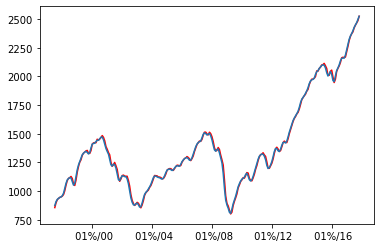

Test RMSE: 15.352


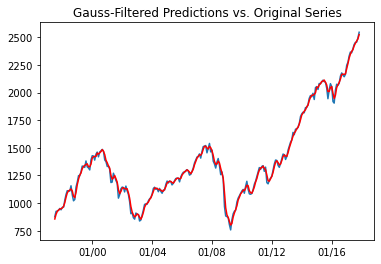

Test RMSE: 24.570


In [ ]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(sp500_ts_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(sp500_ts, predictions, data_split)

                 t-0       t-1
Date                          
2017-06-30  0.708340  0.700751
2017-07-31  0.692660  0.708340
2017-08-31  0.687289  0.692660
2017-09-30  0.706337  0.687289
2017-10-31  0.701951  0.706337


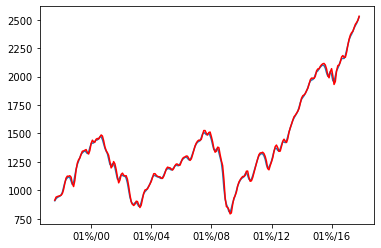

Train RMSE: 2.601
Test RMSE: 17.241


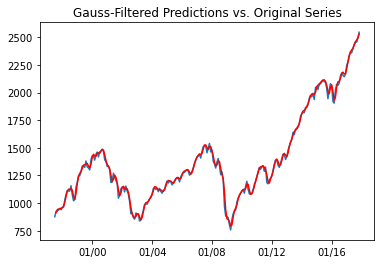

Test RMSE: 25.136


In [ ]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(sp500_ts_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(sp500_ts, test_predict, split)

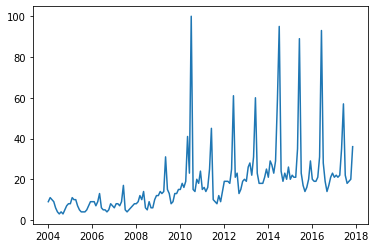

In [ ]:
lebron = pd.Series(pd.read_csv('lebron_james.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype(float)
plt.plot(lebron)

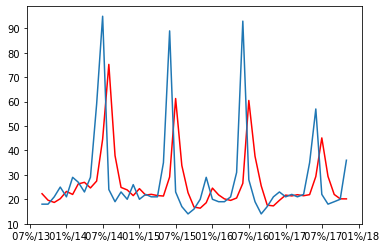

Test RMSE: 20.009


In [ ]:
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(lebron, data_split, params, future_periods, log)

                 t-0       t-1
Month                         
2017-07-01  0.280715  0.708336
2017-08-01  0.503876  0.280715
2017-09-01  0.579538  0.503876
2017-10-01  0.578714  0.579538
2017-11-01  0.738063  0.578714


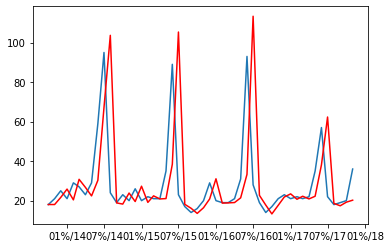

Train RMSE: 16.448
Test RMSE: 25.073


In [ ]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(lebron, look_back, split, transforms, lstm_params)

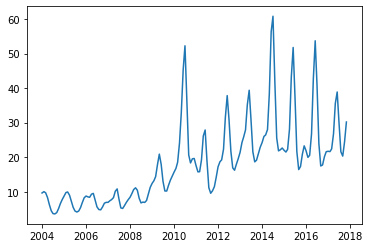

In [ ]:
lebron_gauss = pd.Series(gaussian_filter(lebron, sigma=1), index=lebron.index).astype(float)
plt.plot(lebron_gauss)
plt.show()

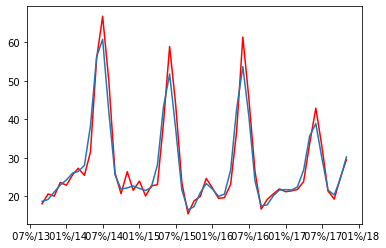

Test RMSE: 3.169


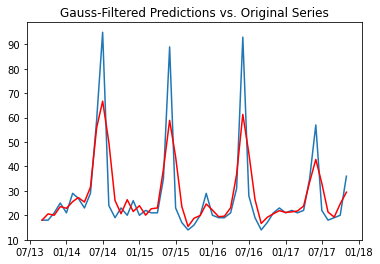

Test RMSE: 9.816


In [ ]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(lebron_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(lebron, predictions, data_split)

                 t-0       t-1
Month                         
2017-07-01  0.294447  0.631607
2017-08-01  0.223928  0.294447
2017-09-01  0.487184  0.223928
2017-10-01  0.723249  0.487184
2017-11-01  0.752657  0.723249


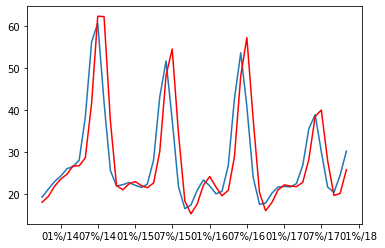

Train RMSE: 3.483
Test RMSE: 7.159


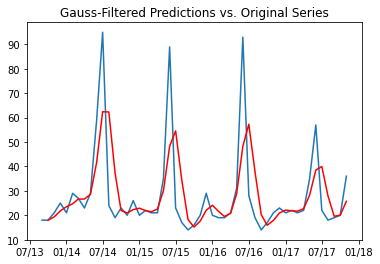

Test RMSE: 14.506


In [ ]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(lebron_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(lebron, test_predict, split)

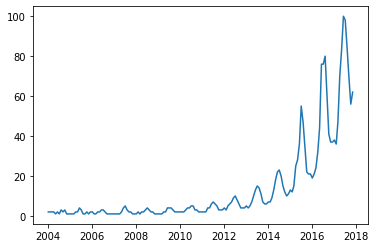

In [ ]:
coldbrew = pd.Series(pd.read_csv('coldbrew.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype('float')
plt.plot(coldbrew)

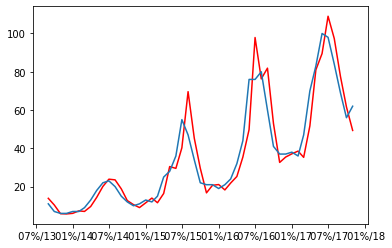

Test RMSE: 9.157


In [ ]:
data_split = 0.7
p = 1
d = 1
q = 0
params = [p, d, q]
future_periods = 12
log = False

predictions, test, forecast = arima_model(coldbrew, data_split, params, future_periods, log)

                 t-0       t-1
Month                         
2017-07-01  0.346154  0.711538
2017-08-01  0.115385  0.346154
2017-09-01  0.096154  0.115385
2017-10-01  0.134615  0.096154
2017-11-01  0.500000  0.134615


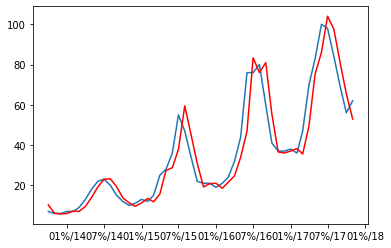

Train RMSE: 1.095
Test RMSE: 8.908


In [ ]:
look_back = 1
split = 0.7
log = False
difference = True
transforms = [log, difference]

nodes = 4
epochs = 4
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(coldbrew, look_back, split, transforms, lstm_params)

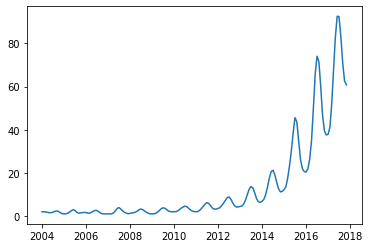

In [ ]:
coldbrew_gauss = pd.Series(gaussian_filter(coldbrew, sigma=1), index=coldbrew.index).astype(float)
plt.plot(coldbrew_gauss)
plt.show()

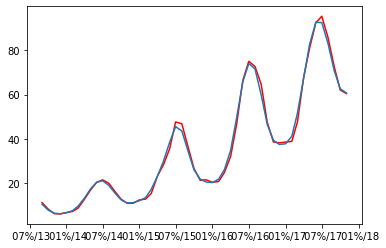

Test RMSE: 1.591


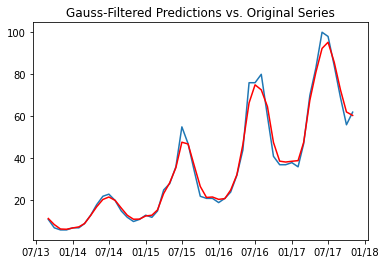

Test RMSE: 3.025


In [ ]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(coldbrew_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(coldbrew, predictions, data_split)

                 t-0       t-1
Month                         
2017-07-01  0.452048  0.576831
2017-08-01  0.336976  0.452048
2017-09-01  0.280309  0.336976
2017-10-01  0.320526  0.280309
2017-11-01  0.420312  0.320526


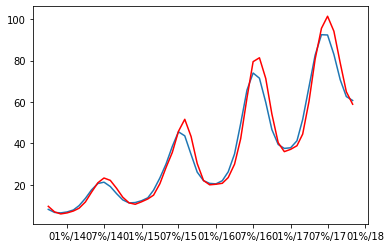

Train RMSE: 0.497
Test RMSE: 4.557


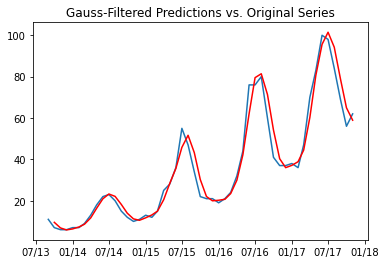

Test RMSE: 5.087


In [ ]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 20
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(coldbrew_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(coldbrew, test_predict, split)

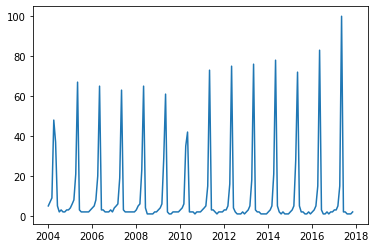

In [ ]:
kyderby = pd.Series(pd.read_csv('kentucky_derby.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype('float')
plt.plot(kyderby)

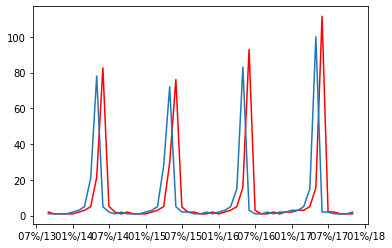

Test RMSE: 30.935


In [ ]:
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(kyderby, data_split, params, future_periods, log)

                 t-0       t-1
Month                         
2017-07-01  0.673425  0.000000
2017-08-01  0.554105  0.673425
2017-09-01  0.673425  0.554105
2017-10-01  0.673425  0.673425
2017-11-01  0.792745  0.673425


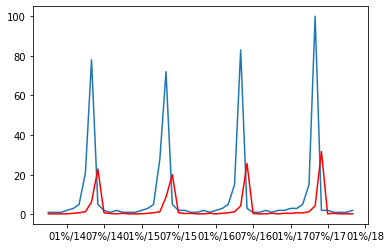

Train RMSE: 19.086
Test RMSE: 23.699


In [ ]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 2
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(kyderby, look_back, split, transforms, lstm_params)

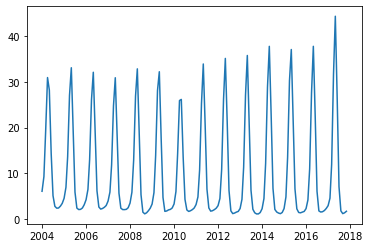

In [ ]:
kyderby_gauss = pd.Series(gaussian_filter(kyderby, sigma=1), index=kyderby.index).astype(float)
plt.plot(kyderby_gauss)
plt.show()

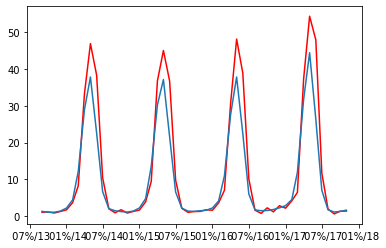

Test RMSE: 5.953


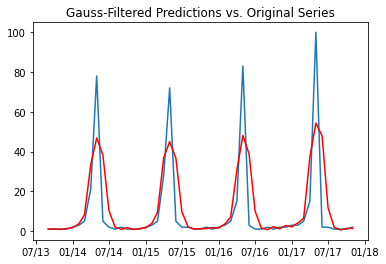

Test RMSE: 15.232


In [ ]:

# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 1
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(kyderby_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussian filter to original series
gauss_compare(kyderby, predictions, data_split)

                 t-0       t-1
Month                         
2017-07-01  0.032377  0.359838
2017-08-01  0.000000  0.032377
2017-09-01  0.396289  0.000000
2017-10-01  0.631226  0.396289
2017-11-01  0.669005  0.631226


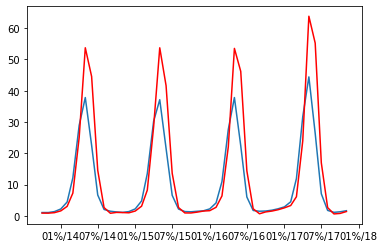

Train RMSE: 6.965
Test RMSE: 8.877


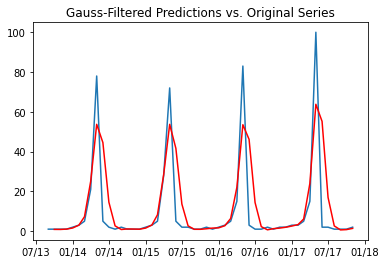

Test RMSE: 15.216


In [ ]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 50
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(kyderby_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(kyderby, test_predict, split)

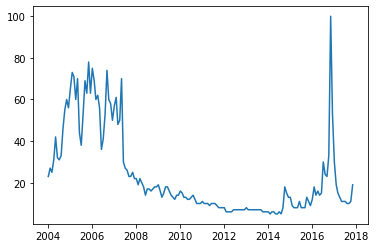

In [ ]:
gilmore_girls = pd.Series(pd.read_csv('gilmoregirls.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype(float)
plt.plot(gilmore_girls)

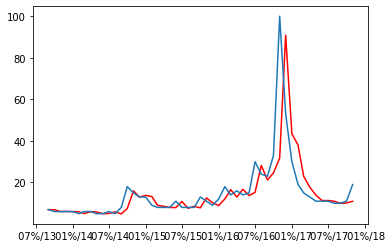

Test RMSE: 12.026


In [ ]:
data_split = 0.7
p = 2
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(gilmore_girls, data_split, params, future_periods, log)

                 t-0       t-1
Month                         
2017-07-01  0.412281  0.412281
2017-08-01  0.403509  0.412281
2017-09-01  0.412281  0.403509
2017-10-01  0.421053  0.412281
2017-11-01  0.482456  0.421053


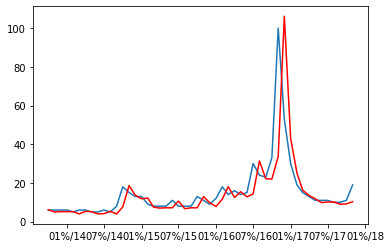

Train RMSE: 7.898
Test RMSE: 12.851


In [ ]:

look_back = 1
split = 0.7
log = False
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(gilmore_girls, look_back, split, transforms, lstm_params)

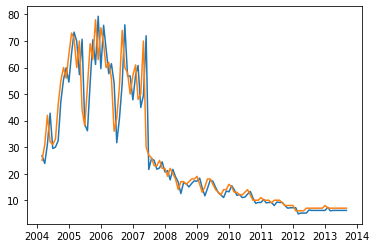

In [ ]:
plt.plot(train_predict)
plt.plot(y_train)

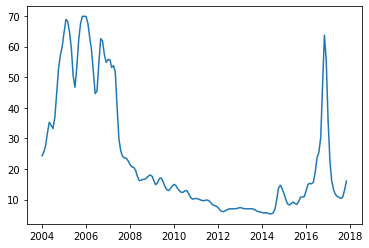

In [ ]:
gilmore_girls_gauss = pd.Series(gaussian_filter(gilmore_girls, sigma=1), index=gilmore_girls.index).astype(float)
plt.plot(gilmore_girls_gauss)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/s

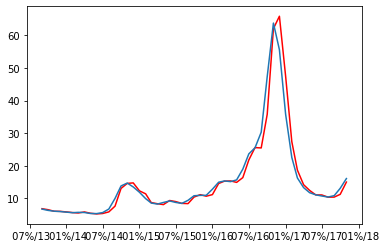

Test RMSE: 3.019


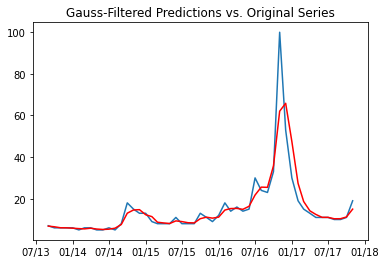

Test RMSE: 6.517


In [ ]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(gilmore_girls_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussian filter to original series
gauss_compare(gilmore_girls, predictions, data_split)

                 t-0       t-1
Month                         
2017-07-01  0.473413  0.445006
2017-08-01  0.475943  0.473413
2017-09-01  0.553713  0.475943
2017-10-01  0.716193  0.553713
2017-11-01  0.735654  0.716193


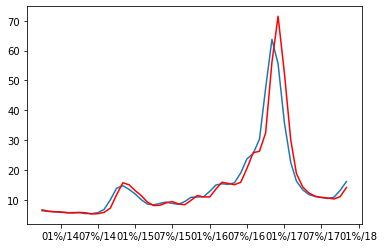

Train RMSE: 2.496
Test RMSE: 4.371


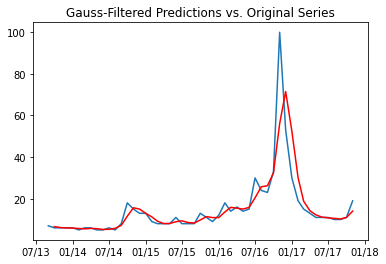

Test RMSE: 7.934


In [ ]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 20
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(gilmore_girls_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(gilmore_girls, test_predict, split)

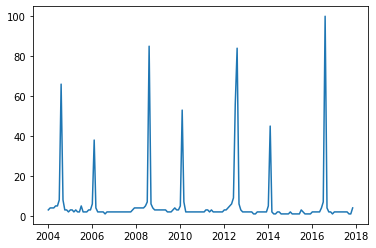

In [43]:
olympics = pd.Series(pd.read_csv('olympics.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype(float)
plt.plot(olympics)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


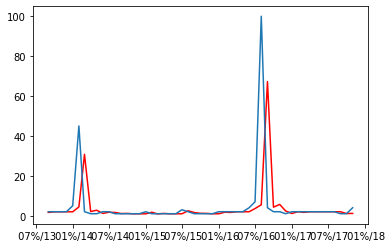

Test RMSE: 17.420


In [44]:
data_split = 0.7
p = 2
d = 2
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(olympics, data_split, params, future_periods, log)

                 t-0       t-1
Month                         
2017-07-01  0.507937  0.507937
2017-08-01  0.507937  0.507937
2017-09-01  0.502646  0.507937
2017-10-01  0.507937  0.502646
2017-11-01  0.523810  0.507937


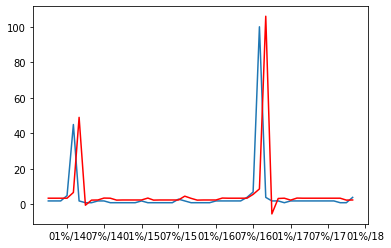

Train RMSE: 17.846
Test RMSE: 21.241


In [45]:
look_back = 1
split = 0.7
log = False
difference = True
transforms = [log, difference]

nodes = 4
epochs = 25
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(olympics, look_back, split, transforms, lstm_params)

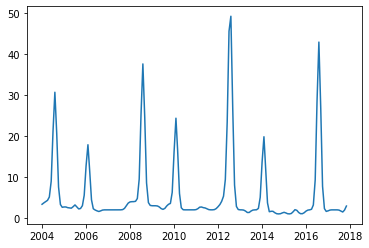

In [46]:
olympics_gauss = pd.Series(gaussian_filter(olympics, sigma=1), index=gilmore_girls.index).astype(float)
plt.plot(olympics_gauss)
plt.show()

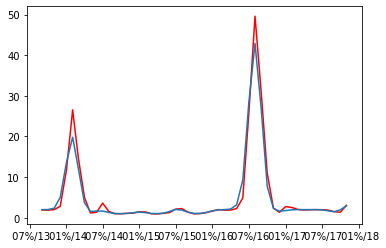

Test RMSE: 1.817


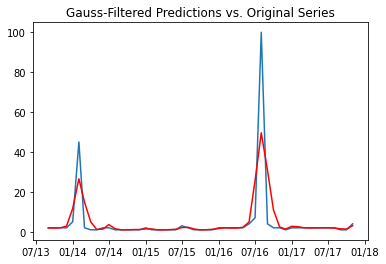

Test RMSE: 9.146


In [47]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 2
d = 1
q = 0
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(olympics_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussian filter to original series
gauss_compare(olympics, predictions, data_split)


                 t-0       t-1
Month                         
2017-07-01  0.515841  0.526468
2017-08-01  0.474162  0.515841
2017-09-01  0.464025  0.474162
2017-10-01  0.645049  0.464025
2017-11-01  0.700858  0.645049


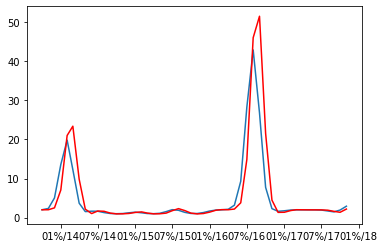

Train RMSE: 4.865
Test RMSE: 4.985


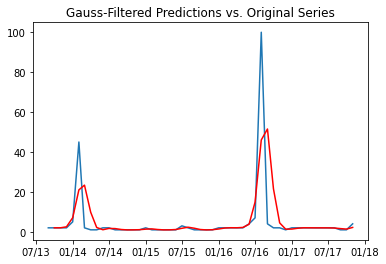

Test RMSE: 11.616


In [48]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 20
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(olympics_gauss, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(olympics, test_predict, split)

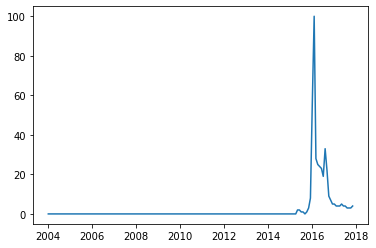

In [49]:
zika = pd.Series(pd.read_csv('zika.csv', header=1, parse_dates=['Month'], index_col="Month").iloc[:,0]).astype('float')
plt.plot(zika)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


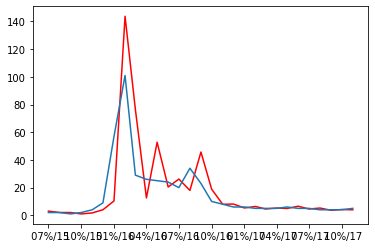

Test RMSE: 16.771


In [50]:
data_split = 0.83
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(zika+1, data_split, params, future_periods, log)

                 t-0       t-1
Month                         
2017-07-01  0.403350  0.344416
2017-08-01  0.331221  0.403350
2017-09-01  0.403350  0.331221
2017-10-01  0.403350  0.403350
2017-11-01  0.475480  0.403350


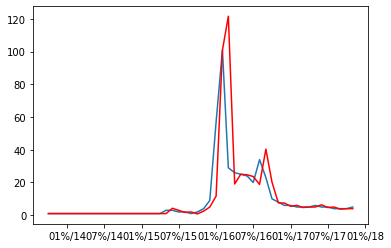

Train RMSE: 0.000
Test RMSE: 15.078


In [51]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 10
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(zika+1, look_back, split, transforms, lstm_params)

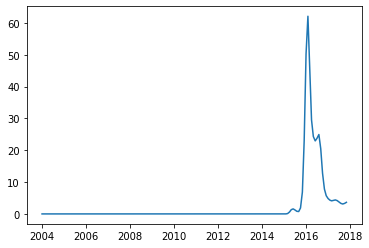

In [52]:
zika_gauss = pd.Series(gaussian_filter(zika, sigma=1), index=zika.index).astype(float)
plt.plot(zika_gauss)
plt.show()

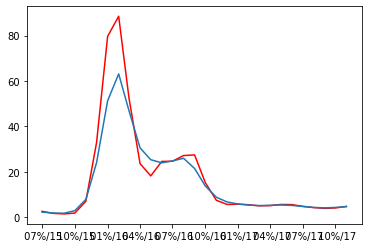

Test RMSE: 7.664


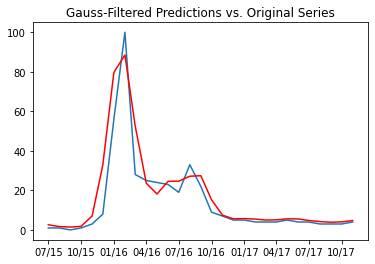

Test RMSE: 8.543


In [53]:
# running ARIMA model with Gaussian Filter
data_split = 0.83
p = 1
d = 2
q = 0
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(zika_gauss+1, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussian filter to original series
gauss_compare(zika, predictions, data_split)

                 t-0       t-1
Month                         
2017-07-01  0.230133  0.259905
2017-08-01  0.222786  0.230133
2017-09-01  0.256230  0.222786
2017-10-01  0.313202  0.256230
2017-11-01  0.334021  0.313202


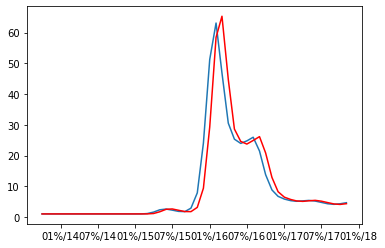

Train RMSE: 0.000
Test RMSE: 5.280


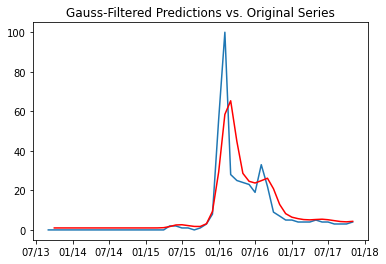

Test RMSE: 9.576


In [54]:
# running LSTM with Gaussian-filtered data
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 20
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(zika_gauss+1, look_back, split, transforms, lstm_params)

# comparing gaussian model results to original data
gauss_compare(zika, test_predict, split)